## VOC Data Tour    
2017년 3월 26일, by kangDJ  
(수정) 2017년 6월 22일, XML_preprocessor, (재수정) 2017/09/20    

Bounding box와 함께 overlap된 이미지의 저장 방법도 배울 수 있다.    

In [1]:
import numpy as np
import os
from xml.etree import ElementTree

from scipy.misc import imread, imresize, imsave
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import pdb

http://host.robots.ox.ac.uk/pascal/VOC/ 에서   
##### VOC data를 다운 받아 압축을 풀면 Anotations 폴더 아래에 xml 파일들이 있다.  
##### xml 파일에는 또 다른 폴더 JPEGImages 내의  원본 이미지에 대한 box 좌표 정보, 이미지 이름, 각 박스의 부류 정보 등이 들어 있다.  
##### 아래의 Class는 xml을 읽어 필요한 Gournd Truth 정보를 가져온다.   

(수정사항) voc2012를 다운받으면 2007~2012로 시작하는 파일들이 함께 들어 있는데, 이중에서 특정 연도의 파일의 box정보만  
추출하기 위해서 __init__, _preprocess_XML 파일의 관련부분을 수정하였다.   

(예) 호출할 때 연도 정보를 넘기지 않으면 모든 파일에 대해서,  
data = XML_preprocessor('VOC2012/Annotations/').data   

연도를 넘기면 해당 연도의 파일의 box정보만 추출  
data = XML_preprocessor('VOC2012/Annotations/', ['2012']).data   

In [2]:
# 이 클래스는 SSD를 다운 받으면 있다.
class XML_preprocessor(object):

    def __init__(self, data_path, prefix=""):
        self.path_prefix = data_path
        self.prefix = prefix
        self.num_classes = 20
        self.data = dict()
        self._preprocess_XML()

    def _preprocess_XML(self):
        #filenames = os.listdir(self.path_prefix)
        filenames = [fn for fn in os.listdir(self.path_prefix) 
                     if any(fn.startswith(year) for year in self.prefix) ]
        
        for filename in filenames:
            
                #if filename.startswith(self.prefix):
                
                tree = ElementTree.parse(self.path_prefix + filename)
                root = tree.getroot()
                bounding_boxes = []
                one_hot_classes = []

                size_tree = root.find('size')
                width = float(size_tree.find('width').text)
                height = float(size_tree.find('height').text)


                for object_tree in root.findall('object'):

                    # original: object 밑의 모든 bndbox을 iter하면서 값 취함
                    """
                    for bounding_box in object_tree.iter('bndbox'):

                        xmin = float(bounding_box.find('xmin').text)/width
                        ymin = float(bounding_box.find('ymin').text)/height
                        xmax = float(bounding_box.find('xmax').text)/width
                        ymax = float(bounding_box.find('ymax').text)/height
                    """

                    bndbox = object_tree.find('bndbox') #object 아래의 첫번째 bndbox만 가져옴 

                    xmin = float(bndbox.find('xmin').text)/width
                    ymin = float(bndbox.find('ymin').text)/height
                    xmax = float(bndbox.find('xmax').text)/width
                    ymax = float(bndbox.find('ymax').text)/height



                    bounding_box = [xmin,ymin,xmax,ymax]
                    bounding_boxes.append(bounding_box)
                    class_name = object_tree.find('name').text
                    one_hot_class = self._to_one_hot(class_name)
                    one_hot_classes.append(one_hot_class)

                image_name = root.find('filename').text
                bounding_boxes = np.asarray(bounding_boxes)
                one_hot_classes = np.asarray(one_hot_classes)
                image_data = np.hstack((bounding_boxes, one_hot_classes))

                self.data[image_name] = image_data

            
    def _to_one_hot(self,name):
        one_hot_vector = [0] * self.num_classes
        if name == 'aeroplane':       # 0
            one_hot_vector[0] = 1
        elif name == 'bicycle':
            one_hot_vector[1] = 1
        elif name == 'bird':
            one_hot_vector[2] = 1
        elif name == 'boat':
            one_hot_vector[3] = 1
        elif name == 'bottle':
            one_hot_vector[4] = 1
        elif name == 'bus':         #5
            one_hot_vector[5] = 1
        elif name == 'car':
            one_hot_vector[6] = 1
        elif name == 'cat':
            one_hot_vector[7] = 1
        elif name == 'chair':
            one_hot_vector[8] = 1
        elif name == 'cow':
            one_hot_vector[9] = 1
        elif name == 'diningtable':  #10
            one_hot_vector[10] = 1
        elif name == 'dog':
            one_hot_vector[11] = 1
        elif name == 'horse':
            one_hot_vector[12] = 1
        elif name == 'motorbike':
            one_hot_vector[13] = 1
        elif name == 'person':
            one_hot_vector[14] = 1
        elif name == 'pottedplant':   #15
            one_hot_vector[15] = 1
        elif name == 'sheep':
            one_hot_vector[16] = 1
        elif name == 'sofa':
            one_hot_vector[17] = 1
        elif name == 'train':
            one_hot_vector[18] = 1
        elif name == 'tvmonitor':
            one_hot_vector[19] = 1
        else:
            print('unknown label: %s' %name)

        return one_hot_vector

## example on how to use it

#### 어떤 폴더 내에 모든 파일 이름 가져오기  

In [6]:
path_prefix = 'VOC2012/Annotations/'
files = []
filenames = os.listdir(path_prefix)
for file in filenames:
    if file.startswith(""):
        files.append(file)

print (files[:5]) # first five files
print (files[-5:]) # last five files

['2007_000027.xml', '2007_000032.xml', '2007_000033.xml', '2007_000039.xml', '2007_000042.xml']
['2012_004326.xml', '2012_004328.xml', '2012_004329.xml', '2012_004330.xml', '2012_004331.xml']


#### 각 년도로 시작하는 파일이 폴더 내에 몇 개인지를 세어서 출력한다. 

In [4]:
years = [['2007'], ['2008'], ['2009'], ['2010'], ['2011'], ['2012']]

for year in years:
    data = XML_preprocessor('VOC2012/Annotations/', year).data
    print ('#({}) = {}'.format(year, len(data)))

    filename = 'gt_VOC{}_{}.pkl'.format(year, len(data))
    pickle.dump(data,open(filename,'wb'))
    

#(['2007']) = 756
#(['2008']) = 4340
#(['2009']) = 2722
#(['2010']) = 3503
#(['2011']) = 3640
#(['2012']) = 2164


#### 연도별로 다양한 결합의 예  

In [11]:
year = ['2007', '2010']
data = XML_preprocessor('VOC2012/Annotations/',  year).data
print ('#({}) = {}'.format(year, len(data)))
pickle.dump(data,open('gt_'+str(year)+'.pkl','wb')) 

#(['2007', '2010']) = 4259


In [12]:
year = ['2007', '2011']
data = XML_preprocessor('VOC2012/Annotations/',  year).data
print ('#({}) = {}'.format(year, len(data)))
pickle.dump(data,open('gt_'+str(year)+'.pkl','wb')) 

#(['2007', '2011']) = 4396


In [13]:
year = ['2009', '2012']
data = XML_preprocessor('VOC2012/Annotations/',  year).data
print ('#({}) = {}'.format(year, len(data)))
pickle.dump(data,open('gt_'+str(year)+'.pkl','wb')) 

#(['2009', '2012']) = 4886


#### 저장한 pkl 파일을 읽어서 Ground Truth 정보 얻기 

In [26]:
year = ['2007', '2010']  
data = pickle.load(open('gt_'+str(year)+'.pkl', 'rb'))

data는 dict 타입으로 저장되어 있다.  

data.keys()는 list 타입이고 첫번째 이미지 파일명에 대한 GT 정보는  
value = data[data.keys()[0]]   

value의 list는 data.values()로 가져온다.  

In [27]:
print (type(data))

<class 'dict'>


In [28]:
vkeys = sorted(data.keys())  #key를 정렬
print (vkeys[:10]) # key는 파일의 이름이다.
print 
print ('# of image data=', len(data.keys()))  

['2007_000027.jpg', '2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg', '2007_000061.jpg', '2007_000063.jpg', '2007_000068.jpg', '2007_000121.jpg', '2007_000123.jpg']
# of image data= 4259


In [33]:
print (vkeys[1])
vlist = list(data.values())
print (vlist[1])

2007_000032.jpg
[[ 0.464       0.45333333  0.906       0.95733333  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]]


##### 데이터에 대한 설명    
voc data는 20개의 물체 카테고리가 있다.  
vkeys[1]는 2007_000032.jpg 파일인데 비행기가 2대와 사람 2명이 있는  있는 영상이다.  
따라서 box정보는 4개이고 부류는 one-hot vector이니 20개의 값이 있다.  
  
만일 하나의 영상 내에 여러 물체와 box가 있다면 list 내에 list가 복수개 있다.  

In [35]:
im_key = '2007_000032.jpg'
boxes = data[im_key].copy()
print (boxes)  # box[:3]: bb 좌표,  box[4:]: 부류 

[[ 0.208       0.27758007  0.75        0.65124555  1.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.266       0.31316726  0.394       0.43772242  1.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.39        0.6405694   0.426       0.81494662  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.052       0.67259786  0.088       0.84697509  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        

##### image data의 크기 

In [38]:
imname = 'VOC2012/JPEGImages/' + im_key
img = imread(imname).astype('float32')
print (img.shape)

(281, 500, 3)


##### bounding box의 좌표 

In [42]:
box_id = 0 # first box
box = boxes[box_id] 
print (boxes[box_id][:4])
print ('bounding box coord = ', box[:4])
xmin = int(round(box[0]*img.shape[1]))
ymin = int(round(box[1]*img.shape[0]))
xmax = int(round(box[2]*img.shape[1]))
ymax = int(round(box[3]*img.shape[0]))

print ('bb coord. in pixels= ', xmin, ymin, xmax, ymax) 


[ 0.208       0.27758007  0.75        0.65124555]
bounding box coord =  [ 0.208       0.27758007  0.75        0.65124555]
bb coord. in pixels=  104 78 375 183


### 원본 이미지와 bb를 출력  
##### box별로 다른 색깔 할당   

In [43]:
coord = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
colors = plt.cm.hsv(np.linspace(0,1,4)).tolist() # 서로 다른 색을 4개 생성 
print (coord)
print (colors)

((104, 78), 272, 106)
[[1.0, 0.0, 0.0, 1.0], [0.03124934374934376, 1.0, 1.3125013124790507e-06, 1.0], [0.0, 0.062501968751969, 1.0, 1.0], [1.0, 0.0, 0.09375, 1.0]]


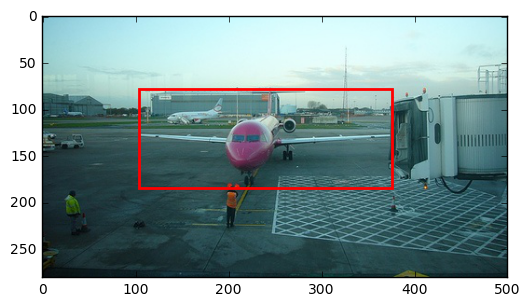

In [44]:
currentAxis = plt.gca() #Get Current Axis
currentAxis.add_patch(plt.Rectangle(*coord, fill=False, edgecolor=colors[0], linewidth=2))
plt.imshow(img/256.)
plt.show()

영상을 (300,300) 크기로 만들고 내부 box도 이에 마추어 크기 조정  

In [45]:
def box_coord(box, im):
    xmin = int(round(box[0]*im.shape[1]))
    ymin = int(round(box[1]*im.shape[0]))
    xmax = int(round(box[2]*im.shape[1]))
    ymax = int(round(box[3]*im.shape[0]))

    coord = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    return coord

In [46]:
im = imresize(imread(imname), (300, 300,3))
print (im.shape)
print (box[:4])
coord = box_coord(box, im) 
print (coord)



(300, 300, 3)
[ 0.208       0.27758007  0.75        0.65124555]
((62, 83), 164, 113)


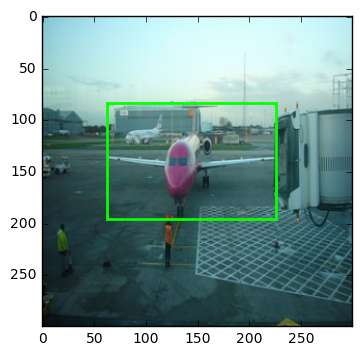

In [47]:
currentAxis = plt.gca()
currentAxis.add_patch(plt.Rectangle(*coord, fill=False, edgecolor=colors[1], linewidth=2))

plt.imshow(im/256.)
plt.show()

### 아래의 명령셋은 폴더 내의 모든 이미지를 읽어서     
(!) RESIZEImages 폴더: 이미지 크기를 (300,300)으로 바꾸어 저장    
(2) BOXImages 폴더: 영상 내의 물체에 bounding box를 표시해서 저장  
단, RESIZEImages, BOXImages 폴더는 미리 만들어 주어야 한다.  


In [ ]:
src_path = 'VOC2012/JPEGImages/'
tgt_path = 'VOC2012/RESIZEImages/'
box_path = 'VOC2012/BOXImages/'

for idx, vkey in enumerate(vkeys):
    #print vkey
    srcname = src_path + vkey
    im = imresize(imread(srcname), (300, 300,3))
    
    tgtname = tgt_path + vkey # jpg파일을 저장
    #tgtname = tgt_path + vkey[:-3] + '.png' # png파일을 저장 시.
    imsave(tgtname, im)
    
    boxname = box_path + vkey
    boxes = data[vkey].copy()
    
    currentAxis = plt.gca()
    plt.imshow(im/256.)

    for box in boxes:
        coord = box_coord(box, im)  
        currentAxis.add_patch(plt.Rectangle(*coord, fill=False, edgecolor=colors[1], linewidth=2))
    
    plt.savefig(boxname)  #이미지 위에 patch추가한(overlap) plot를 디스크에 저장 
    plt.clf() # reset current plot

In [ ]:
src_path = 'VOC2012/JPEGImages/'
tgt_path = 'VOC2012/RESIZEImages/'
box_path = 'VOC2012/BOXImages/'

for idx, vkey in enumerate(vkeys):
    #print vkey
    srcname = src_path + vkey
    im = imresize(imread(srcname), (300, 300,3))
    
    tgtname = tgt_path + vkey # jpg파일을 저장
    #tgtname = tgt_path + vkey[:-3] + '.png' # png파일을 저장 시.
    imsave(tgtname, im)
    
    boxname = box_path + vkey
    boxes = data[vkey].copy()
    
    currentAxis = plt.gca()
    plt.imshow(im/256.)

    for box in boxes:
        coord = box_coord(box, im)  
        currentAxis.add_patch(plt.Rectangle(*coord, fill=False, edgecolor=colors[1], linewidth=2))
    
    plt.savefig(boxname)  #이미지 위에 patch추가한(overlap) plot를 디스크에 저장 
    plt.clf() # reset current plot

In [ ]:
src_path = 'VOC2012/JPEGImages/'
tgt_path = 'VOC2012/RESIZEImages/'
box_path = 'VOC2012/BOXImages/'

for idx, vkey in enumerate(vkeys):
    #print vkey
    srcname = src_path + vkey
    im = imresize(imread(srcname), (300, 300,3))
    
    tgtname = tgt_path + vkey # jpg파일을 저장
    #tgtname = tgt_path + vkey[:-3] + '.png' # png파일을 저장 시.
    imsave(tgtname, im)
    
    boxname = box_path + vkey
    boxes = data[vkey].copy()
    
    currentAxis = plt.gca()
    plt.imshow(im/256.)

    for box in boxes:
        coord = box_coord(box, im)  
        currentAxis.add_patch(plt.Rectangle(*coord, fill=False, edgecolor=colors[1], linewidth=2))
    
    plt.savefig(boxname)  #이미지 위에 patch추가한(overlap) plot를 디스크에 저장 
    plt.clf() # reset current plot